In [3]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Load COCO annotations
with open('_annotations.coco.json') as f:
    coco_data = json.load(f)

# Create directories
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/masks', exist_ok=True)
os.makedirs('dataset/images/train', exist_ok=True)
os.makedirs('dataset/masks/train', exist_ok=True)
os.makedirs('dataset/images/val', exist_ok=True)
os.makedirs('dataset/masks/val', exist_ok=True)

print("Preparing dataset...")

# Prepare image and mask paths
image_mask_pairs = []

for img_info in tqdm(coco_data['images'], desc="Processing images"):
    img_id = img_info['id']
    img_filename = img_info['file_name']
    height = img_info['height']
    width = img_info['width']

    # Load original image
    img = cv2.imread(img_filename)
    if img is None:
        print(f"Warning: Could not load image {img_filename}")
        continue

    # Get annotations for this image
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_id]

    # Create mask
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in annotations:
        if 'segmentation' in ann and ann['segmentation']:
            for seg in ann['segmentation']:
                if isinstance(seg, list):
                    poly = np.array(seg).reshape((len(seg)//2, 2))
                    cv2.fillPoly(mask, [np.int32(poly)], 1)

    # Resize to standard size (256x256 is common for UNet)
    target_size = (256, 256)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

    # Convert mask to binary (0 and 255)
    mask_binary = (mask_resized > 0).astype(np.uint8) * 255

    # Save resized image and mask
    base_name = os.path.splitext(os.path.basename(img_filename))[0]
    img_path = f"dataset/images/{base_name}.png"
    mask_path = f"dataset/masks/{base_name}_mask.png"

    cv2.imwrite(img_path, img_resized)
    cv2.imwrite(mask_path, mask_binary)

    image_mask_pairs.append((img_path, mask_path))

print(f"Prepared {len(image_mask_pairs)} image-mask pairs")

Preparing dataset...


Processing images: 100%|██████████| 72/72 [00:00<00:00, 144.53it/s]

Prepared 72 image-mask pairs


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    # Block 1
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Block 2
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Block 3
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Block 4
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Upsampling)
    # Block 6
    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    # Block 7
    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    # Block 8
    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    # Block 9
    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

# Create model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
import tensorflow as tf
import albumentations as A  # Install: pip install albumentations

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))

        # Define augmentation pipeline
        self.augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        ])

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_img_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            # Load image and mask
            image = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Normalize image to [0, 1]
            image = image.astype(np.float32) / 255.0

            # Normalize mask to [0, 1]
            mask = mask.astype(np.float32) / 255.0

            # Reshape mask for model output
            mask = np.expand_dims(mask, axis=-1)

            # Apply augmentations if needed
            if self.augment:
                augmented = self.augmentation(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)
        self.image_paths = [self.image_paths[i] for i in self.indexes]
        self.mask_paths = [self.mask_paths[i] for i in self.indexes]

In [7]:
# Split data into train and validation
image_paths = [pair[0] for pair in image_mask_pairs]
mask_paths = [pair[1] for pair in image_mask_pairs]

# Split data (80% train, 20% validation)
train_img, val_img, train_mask, val_mask = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_img)}")
print(f"Validation samples: {len(val_img)}")

# Create data generators
train_gen = DataGenerator(train_img, train_mask, batch_size=4, augment=True)
val_gen = DataGenerator(val_img, val_mask, batch_size=4, augment=False)

# Define callbacks
callbacks = [
    ModelCheckpoint('unet_best_model.h5',
                   monitor='val_iou',
                   mode='max',
                   save_best_only=True,
                   verbose=1),
    EarlyStopping(monitor='val_loss',
                 patience=10,
                 restore_best_weights=True,
                 verbose=1),
    ReduceLROnPlateau(monitor='val_loss',
                     factor=0.5,
                     patience=5,
                     min_lr=1e-6,
                     verbose=1)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Training samples: 57
Validation samples: 15


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6217 - io_u: 0.0000e+00 - loss: 0.6857

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_iou available.
  if self._should_save_model(epoch, batch, logs, filepath):


15/15 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.6248 - io_u: 0.0000e+00 - loss: 0.6848 - val_accuracy: 0.6974 - val_io_u: 0.0000e+00 - val_loss: 0.6515 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6721 - io_u: 0.0000e+00 - loss: 0.6429

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6730 - io_u: 0.0000e+00 - loss: 0.6422 - val_accuracy: 0.6974 - val_io_u: 0.0000e+00 - val_loss: 0.6345 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6940 - io_u: 0.0000e+00 - loss: 0.6096

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - accuracy: 0.6935 - io_u: 0.0000e+00 - loss: 0.6104 - val_accuracy: 0.6974 - val_io_u: 0.0000e+00 - val_loss: 0.6161 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6799 - io_u: 0.0000e+00 - loss: 0.6053

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.6806 - io_u: 0.0000e+00 - loss: 0.6039 - val_accuracy: 0.7200 - val_io_u: 0.0000e+00 - val_loss: 0.5362 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7326 - io_u: 0.0000e+00 - loss: 0.5178

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.7307 - io_u: 0.0000e+00 - loss: 0.5193 - val_accuracy: 0.7595 - val_io_u: 0.0000e+00 - val_loss: 0.5857 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7568 - io_u: 0.0000e+00 - loss: 0.6032

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.7564 - io_u: 0.0000e+00 - loss: 0.6017 - val_accuracy: 0.7312 - val_io_u: 0.0000e+00 - val_loss: 0.4830 - learning_rate: 1.0000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7239 - io_u: 0.0000e+00 - loss: 0.5162

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - accuracy: 0.7243 - io_u: 0.0000e+00 - loss: 0.5170 - val_accuracy: 0.7585 - val_io_u: 0.0000e+00 - val_loss: 0.5118 - learning_rate: 1.0000e-04
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7382 - io_u: 0.0000e+00 - loss: 0.5420

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.7402 - io_u: 0.0000e+00 - loss: 0.5401 - val_accuracy: 0.7839 - val_io_u: 0.0000e+00 - val_loss: 0.4538 - learning_rate: 1.0000e-04
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7665 - io_u: 0.0000e+00 - loss: 0.4949

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.7665 - io_u: 0.0000e+00 - loss: 0.4950 - val_accuracy: 0.7809 - val_io_u: 0.0000e+00 - val_loss: 0.4478 - learning_rate: 1.0000e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7430 - io_u: 0.0000e+00 - loss: 0.5133

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - accuracy: 0.7441 - io_u: 0.0000e+00 - loss: 0.5123 - val_accuracy: 0.7694 - val_io_u: 0.0000e+00 - val_loss: 0.4544 - learning_rate: 1.0000e-04
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7533 - io_u: 0.0000e+00 - loss: 0.4953

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.7548 - io_u: 0.0000e+00 - loss: 0.4939 - val_accuracy: 0.8042 - val_io_u: 0.0000e+00 - val_loss: 0.4835 - learning_rate: 1.0000e-04
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8003 - io_u: 0.0000e+00 - loss: 0.4760

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.7984 - io_u: 0.0000e+00 - loss: 0.4781 - val_accuracy: 0.7926 - val_io_u: 0.0000e+00 - val_loss: 0.4827 - learning_rate: 1.0000e-04
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8029 - io_u: 0.0000e+00 - loss: 0.4839

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.8012 - io_u: 0.0000e+00 - loss: 0.4853 - val_accuracy: 0.8108 - val_io_u: 0.0000e+00 - val_loss: 0.4596 - learning_rate: 1.0000e-04
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7719 - io_u: 0.0000e+00 - loss: 0.4672

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.7724 - io_u: 0.0000e+00 - loss: 0.4666 - val_accuracy: 0.8351 - val_io_u: 0.0000e+00 - val_loss: 0.3697 - learning_rate: 1.0000e-04
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8214 - io_u: 0.0000e+00 - loss: 0.4328

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.8210 - io_u: 0.0000e+00 - loss: 0.4323 - val_accuracy: 0.8422 - val_io_u: 0.0000e+00 - val_loss: 0.3782 - learning_rate: 1.0000e-04
Epoch 16/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8132 - io_u: 0.0000e+00 - loss: 0.4102

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8133 - io_u: 0.0000e+00 - loss: 0.4099 - val_accuracy: 0.8322 - val_io_u: 0.0000e+00 - val_loss: 0.3988 - learning_rate: 1.0000e-04
Epoch 17/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8299 - io_u: 0.0000e+00 - loss: 0.3910

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - accuracy: 0.8292 - io_u: 0.0000e+00 - loss: 0.3921 - val_accuracy: 0.8549 - val_io_u: 0.0000e+00 - val_loss: 0.3399 - learning_rate: 1.0000e-04
Epoch 18/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8065 - io_u: 0.0000e+00 - loss: 0.4244

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8078 - io_u: 0.0000e+00 - loss: 0.4224 - val_accuracy: 0.8413 - val_io_u: 0.0000e+00 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 19/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8309 - io_u: 0.0000e+00 - loss: 0.3848

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.8307 - io_u: 0.0000e+00 - loss: 0.3846 - val_accuracy: 0.8589 - val_io_u: 0.0000e+00 - val_loss: 0.3383 - learning_rate: 1.0000e-04
Epoch 20/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8362 - io_u: 0.0000e+00 - loss: 0.3738

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.8355 - io_u: 0.0000e+00 - loss: 0.3746 - val_accuracy: 0.8547 - val_io_u: 0.0000e+00 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 21/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8296 - io_u: 0.0000e+00 - loss: 0.3849

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step - accuracy: 0.8303 - io_u: 0.0000e+00 - loss: 0.3838 - val_accuracy: 0.8571 - val_io_u: 0.0000e+00 - val_loss: 0.3270 - learning_rate: 1.0000e-04
Epoch 22/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8320 - io_u: 0.0000e+00 - loss: 0.3766

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.8327 - io_u: 0.0000e+00 - loss: 0.3756 - val_accuracy: 0.8577 - val_io_u: 0.0000e+00 - val_loss: 0.3309 - learning_rate: 1.0000e-04
Epoch 23/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8711 - io_u: 0.0000e+00 - loss: 0.3039

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.8694 - io_u: 0.0000e+00 - loss: 0.3067 - val_accuracy: 0.8653 - val_io_u: 0.0000e+00 - val_loss: 0.3112 - learning_rate: 1.0000e-04
Epoch 24/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8565 - io_u: 0.0000e+00 - loss: 0.3449

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.8558 - io_u: 0.0000e+00 - loss: 0.3459 - val_accuracy: 0.8471 - val_io_u: 0.0000e+00 - val_loss: 0.3387 - learning_rate: 1.0000e-04
Epoch 25/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8505 - io_u: 0.0000e+00 - loss: 0.3412

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - accuracy: 0.8500 - io_u: 0.0000e+00 - loss: 0.3422 - val_accuracy: 0.8562 - val_io_u: 0.0000e+00 - val_loss: 0.3180 - learning_rate: 1.0000e-04
Epoch 26/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8512 - io_u: 0.0000e+00 - loss: 0.3390

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.8507 - io_u: 0.0000e+00 - loss: 0.3397 - val_accuracy: 0.8668 - val_io_u: 0.0000e+00 - val_loss: 0.2958 - learning_rate: 1.0000e-04
Epoch 27/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8423 - io_u: 0.0000e+00 - loss: 0.3526

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - accuracy: 0.8424 - io_u: 0.0000e+00 - loss: 0.3527 - val_accuracy: 0.8633 - val_io_u: 0.0000e+00 - val_loss: 0.3271 - learning_rate: 1.0000e-04
Epoch 28/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8439 - io_u: 0.0000e+00 - loss: 0.3401

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - accuracy: 0.8442 - io_u: 0.0000e+00 - loss: 0.3398 - val_accuracy: 0.8552 - val_io_u: 0.0000e+00 - val_loss: 0.3161 - learning_rate: 1.0000e-04
Epoch 29/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8436 - io_u: 0.0000e+00 - loss: 0.3398

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.8438 - io_u: 0.0000e+00 - loss: 0.3396 - val_accuracy: 0.8588 - val_io_u: 0.0000e+00 - val_loss: 0.3066 - learning_rate: 1.0000e-04
Epoch 30/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8514 - io_u: 0.0000e+00 - loss: 0.3377

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.8509 - io_u: 0.0000e+00 - loss: 0.3388 - val_accuracy: 0.8605 - val_io_u: 0.0000e+00 - val_loss: 0.3102 - learning_rate: 1.0000e-04
Epoch 31/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8476 - io_u: 0.0000e+00 - loss: 0.3424


Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - accuracy: 0.8474 - io_u: 0.0000e+00 - loss: 0.3428 - val_accuracy: 0.8323 - val_io_u: 0.0000e+00 - val_loss: 0.3940 - learning_rate: 1.0000e-04
Epoch 32/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8246 - io_u: 0.0000e+00 - loss: 0.3912

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 353ms/step - accuracy: 0.8254 - io_u: 0.0000e+00 - loss: 0.3891 - val_accuracy: 0.8683 - val_io_u: 0.0000e+00 - val_loss: 0.2950 - learning_rate: 5.0000e-05
Epoch 33/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8589 - io_u: 0.0000e+00 - loss: 0.3291

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 480ms/step - accuracy: 0.8587 - io_u: 0.0000e+00 - loss: 0.3289 - val_accuracy: 0.8759 - val_io_u: 0.0000e+00 - val_loss: 0.2765 - learning_rate: 5.0000e-05
Epoch 34/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8353 - io_u: 0.0000e+00 - loss: 0.3735

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.8362 - io_u: 0.0000e+00 - loss: 0.3718 - val_accuracy: 0.8714 - val_io_u: 0.0000e+00 - val_loss: 0.2839 - learning_rate: 5.0000e-05
Epoch 35/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8603 - io_u: 0.0000e+00 - loss: 0.3258

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.8603 - io_u: 0.0000e+00 - loss: 0.3257 - val_accuracy: 0.8682 - val_io_u: 0.0000e+00 - val_loss: 0.2914 - learning_rate: 5.0000e-05
Epoch 36/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8484 - io_u: 0.0000e+00 - loss: 0.3509

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.8476 - io_u: 0.0000e+00 - loss: 0.3527 - val_accuracy: 0.8717 - val_io_u: 0.0000e+00 - val_loss: 0.3066 - learning_rate: 5.0000e-05
Epoch 37/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8382 - io_u: 0.0000e+00 - loss: 0.3641

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.8388 - io_u: 0.0000e+00 - loss: 0.3630 - val_accuracy: 0.8671 - val_io_u: 0.0000e+00 - val_loss: 0.2927 - learning_rate: 5.0000e-05
Epoch 38/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8570 - io_u: 0.0000e+00 - loss: 0.3214


Epoch 38: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - accuracy: 0.8570 - io_u: 0.0000e+00 - loss: 0.3215 - val_accuracy: 0.8601 - val_io_u: 0.0000e+00 - val_loss: 0.2946 - learning_rate: 5.0000e-05
Epoch 39/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8536 - io_u: 0.0000e+00 - loss: 0.3378

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.8539 - io_u: 0.0000e+00 - loss: 0.3368 - val_accuracy: 0.8726 - val_io_u: 0.0000e+00 - val_loss: 0.2831 - learning_rate: 2.5000e-05
Epoch 40/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8766 - io_u: 0.0000e+00 - loss: 0.2930

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.8756 - io_u: 0.0000e+00 - loss: 0.2945 - val_accuracy: 0.8768 - val_io_u: 0.0000e+00 - val_loss: 0.2821 - learning_rate: 2.5000e-05
Epoch 41/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8465 - io_u: 0.0000e+00 - loss: 0.3371

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - accuracy: 0.8474 - io_u: 0.0000e+00 - loss: 0.3354 - val_accuracy: 0.8730 - val_io_u: 0.0000e+00 - val_loss: 0.2812 - learning_rate: 2.5000e-05
Epoch 42/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8614 - io_u: 0.0000e+00 - loss: 0.2992

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8616 - io_u: 0.0000e+00 - loss: 0.2995 - val_accuracy: 0.8787 - val_io_u: 0.0000e+00 - val_loss: 0.2712 - learning_rate: 2.5000e-05
Epoch 43/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8769 - io_u: 0.0000e+00 - loss: 0.2916

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - accuracy: 0.8766 - io_u: 0.0000e+00 - loss: 0.2918 - val_accuracy: 0.8760 - val_io_u: 0.0000e+00 - val_loss: 0.2740 - learning_rate: 2.5000e-05
Epoch 44/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8525 - io_u: 0.0000e+00 - loss: 0.3274

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.8530 - io_u: 0.0000e+00 - loss: 0.3269 - val_accuracy: 0.8795 - val_io_u: 0.0000e+00 - val_loss: 0.2664 - learning_rate: 2.5000e-05
Epoch 45/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8597 - io_u: 0.0000e+00 - loss: 0.3204

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.8601 - io_u: 0.0000e+00 - loss: 0.3196 - val_accuracy: 0.8837 - val_io_u: 0.0000e+00 - val_loss: 0.2628 - learning_rate: 2.5000e-05
Epoch 46/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8490 - io_u: 0.0000e+00 - loss: 0.3288

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.8500 - io_u: 0.0000e+00 - loss: 0.3274 - val_accuracy: 0.8831 - val_io_u: 0.0000e+00 - val_loss: 0.2608 - learning_rate: 2.5000e-05
Epoch 47/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8779 - io_u: 0.0000e+00 - loss: 0.2770

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.8773 - io_u: 0.0000e+00 - loss: 0.2782 - val_accuracy: 0.8825 - val_io_u: 0.0000e+00 - val_loss: 0.2606 - learning_rate: 2.5000e-05
Epoch 48/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8843 - io_u: 0.0000e+00 - loss: 0.2707

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - accuracy: 0.8830 - io_u: 0.0000e+00 - loss: 0.2730 - val_accuracy: 0.8829 - val_io_u: 0.0000e+00 - val_loss: 0.2625 - learning_rate: 2.5000e-05
Epoch 49/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.8682 - io_u: 0.0000e+00 - loss: 0.2952

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.8682 - io_u: 0.0000e+00 - loss: 0.2953 - val_accuracy: 0.8819 - val_io_u: 0.0000e+00 - val_loss: 0.2698 - learning_rate: 2.5000e-05
Epoch 50/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8559 - io_u: 0.0000e+00 - loss: 0.3201

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.8566 - io_u: 0.0000e+00 - loss: 0.3187 - val_accuracy: 0.8787 - val_io_u: 0.0000e+00 - val_loss: 0.2697 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 47.


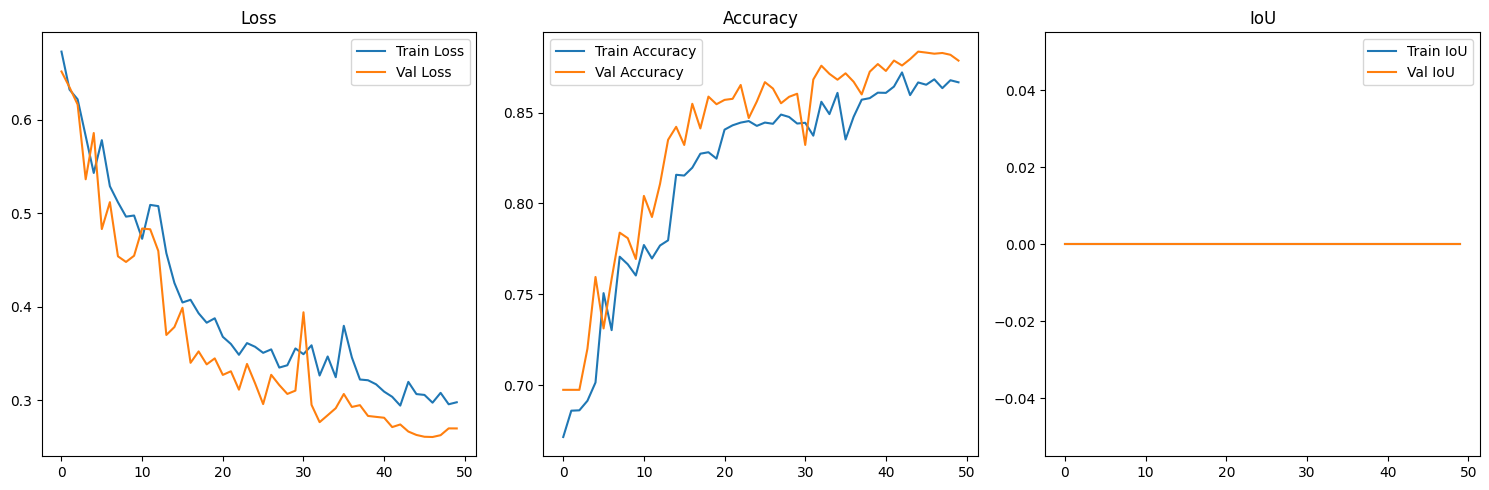

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


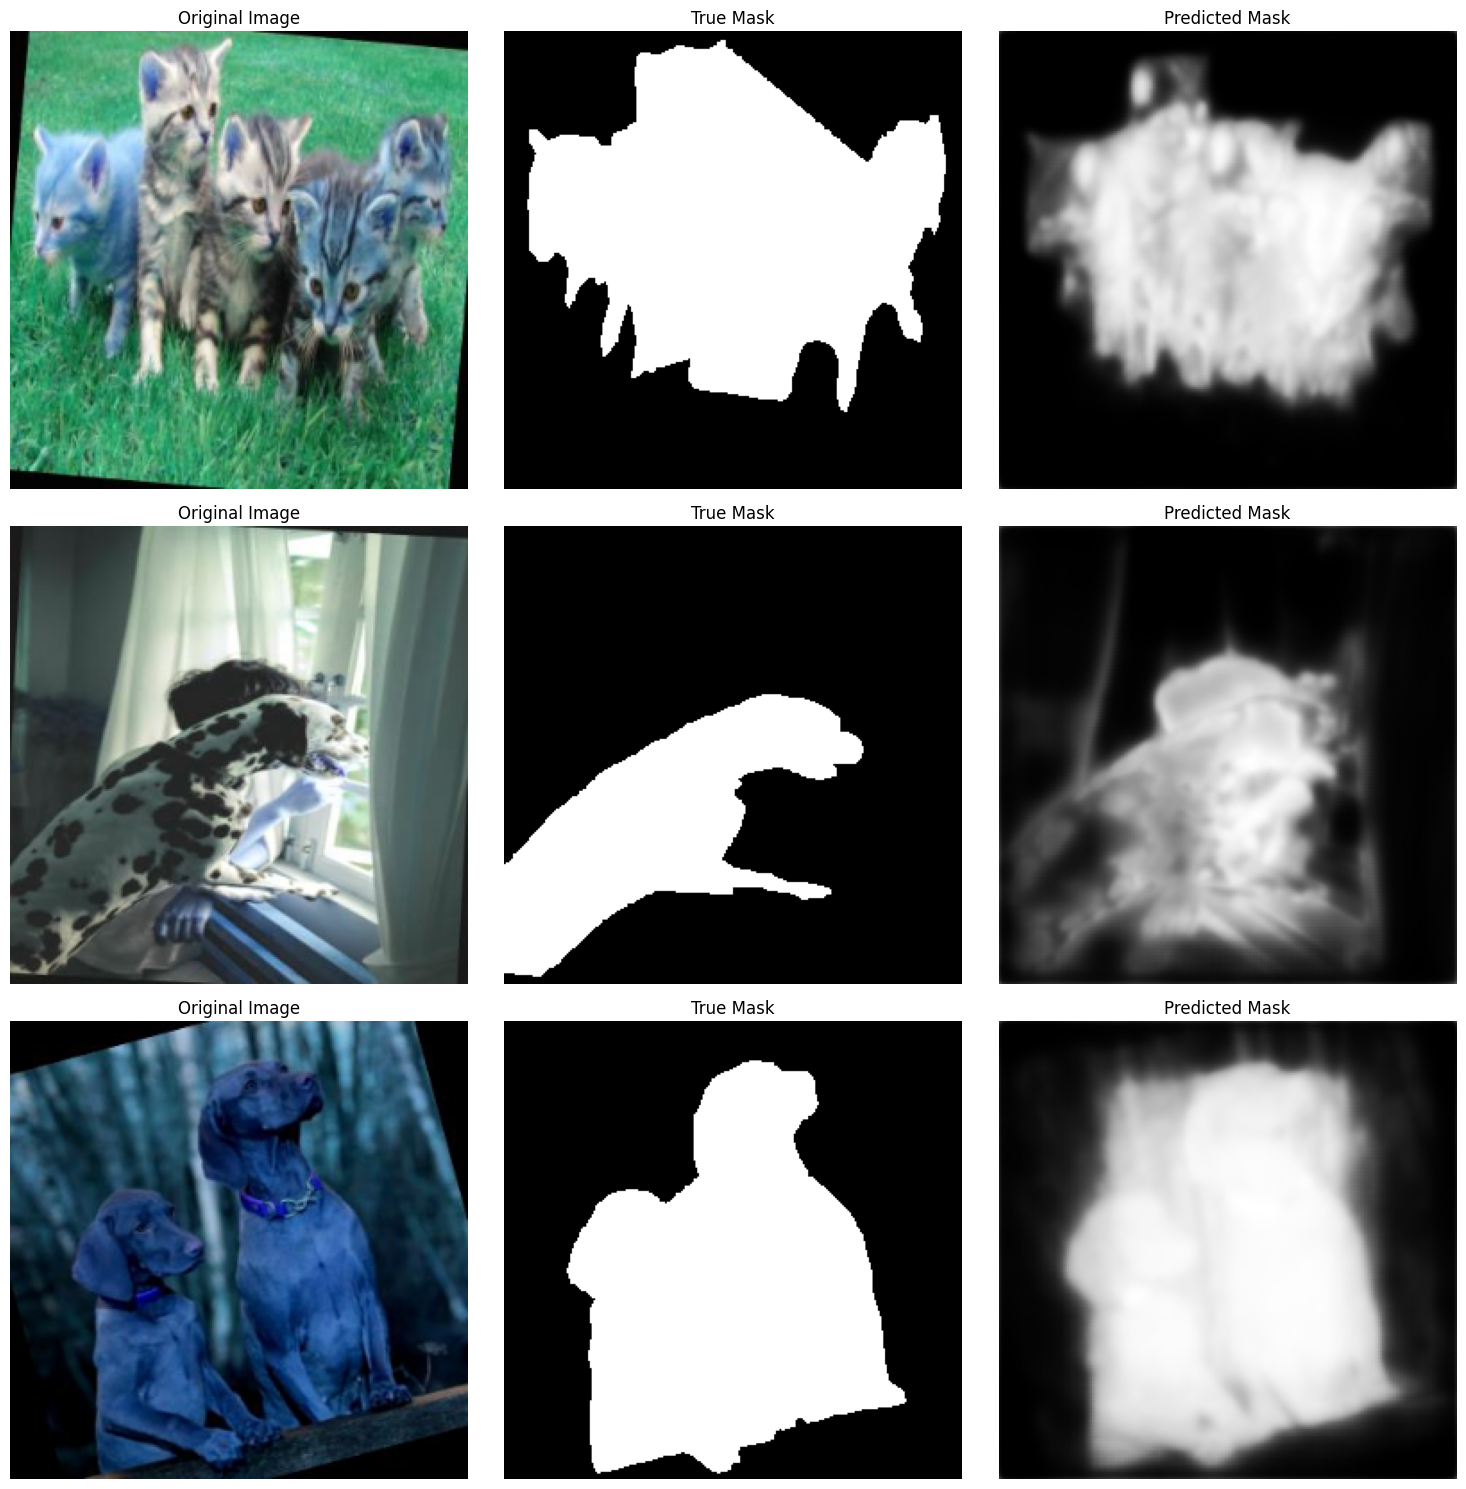

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Train Loss')
    axes[0].plot(history.history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    # Plot accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()

    # Plot IoU
    axes[2].plot(history.history['io_u'], label='Train IoU')
    axes[2].plot(history.history['val_io_u'], label='Val IoU')
    axes[2].set_title('IoU')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Plot training history
plot_training_history(history)

# Function to visualize predictions
def visualize_predictions(model, generator, num_samples=3):
    images, true_masks = next(iter(generator))
    pred_masks = model.predict(images)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*5))

    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # True mask
        axes[i, 1].imshow(true_masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

# Visualize predictions
visualize_predictions(model, val_gen)

In [10]:
def predict_single_image(model, image_path, threshold=0.5):
    """
    Predict segmentation mask for a single image
    """
    # Load and preprocess image
    image = cv2.imread(image_path)
    original_shape = image.shape[:2]

    # Resize to model input size
    image_resized = cv2.resize(image, (256, 256))
    image_normalized = image_resized.astype(np.float32) / 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)

    # Predict
    pred = model.predict(image_batch)[0]

    # Apply threshold
    pred_mask = (pred > threshold).astype(np.uint8) * 255

    # Resize back to original size
    pred_mask_resized = cv2.resize(pred_mask.squeeze(),
                                   (original_shape[1], original_shape[0]),
                                   interpolation=cv2.INTER_NEAREST)

    return pred_mask_resized

# Test on a sample image
sample_image_path = image_paths[0]
predicted_mask = predict_single_image(model, sample_image_path)

# Save the prediction
cv2.imwrite('predicted_mask.png', predicted_mask)
print("Prediction saved as 'predicted_mask.png'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction saved as 'predicted_mask.png'


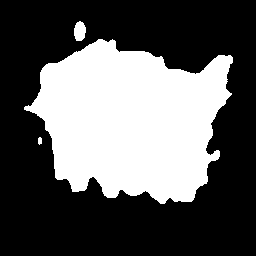